###Comparison of 2-Parameter Method and Ray-Tracing Geolocation and Refractive Index Estimators
                                        

Notes:

###Updates:
20150807: Code has been upgraded to predict great-circle distance and refractive index of scattering locations detected by both 1/2-hop and 1 1/2-hop propagation modes. Differences between ray tracing and 2-Parameter Method predictions remain comparable to those found for 1/2-hop propagation modes. The analyses in this package use the de Larquier ray tracing code that has been altered to allow for propagation to 4000 km in group range and two full hops. Ray tracing program should be modified to allow propagation to be carried to 4000 km group range.

20150919: Code has been modified to allow prediction of 1-hop great-circle ground scatter distances in a tilted ionosphere. In a tilted ionosphere, the elevation angle of arrival and reflection differ from the initial elevation angle at the radar site. Also the lengths of the 3 legs of the propagaion path are all different. The solution is determined in an iterative manner.
*******************************************************************************************************************
Summary

This code evaluates the differences between various techniques for determining the refractive index and
great-circle distance to regions of ionospheric backscatter using the 2-Parameter Method.
It also allows for estimation of great-circle distance errors when using the Standard and 
Chisham Methods of scatter geolocation. The code is currently designed to compare the
predictions with a single 2-D ray tracing using the code developed by Sebastien de Larquier.
The ray tracing code uses the IRI model to provide a realistic ionosphere for the date, time, radar, radar operating frequency and beam direction selected. These values are entered at the beginning of the code.
Be sure to have stime set to the same value as etime in Cell 2 as this code and its associated plotting
code are only designed to compare the results of a single ray tracing. The analysis can be repeated for 
as many different sets of conditions as you wish. 

Note that the elevation angles nominally extend from 8 to 40 degrees in 0.1 degree increments.
This elevation angle range can be changed by altering the first or second parameter in parentheses in Cell 2.
Normally this elevation angle range suffices, but if you select the wrong operating frequecy for the time of
of day, all of the rays that are being analyzed can be reflected by the ionosphere. Normally, it is best to try and have some of the analyzed rays penetrate the ionosphere and some be reflected.

We believe that this code is an excellent training tool. It enables a researcher to see the type of propagation that a specific radar will encounter when operated at a specific time and frequency. The actual propagation on any given day will differ somewhat from the propagation predicted by the IRI model, but, nevertheless, prediction and reality will display some similarities. This software determines the consistancy that exists between ray-tracing analyses of the great circle distance to ionospheric scattering volumes and the great circle distance predicted by the SuperDARN Standard Method, the SuperDARN Chisham Method and a new 2-Parameter Method. The Standard Method uses the group range to the scattering volume and an assumption of the virtual height, e.g. 350 km, to estimate the great-circle distance. The Chisham method uses a range-dependent virtual height that is derived from averaging 5-years of elevation angle data derived from the SuperDARN interferometery technique and the group range for its determinations of the great circle distance. The 2-Parameter Method is new and requires determinations of both the group range and the initial (or final) elevation angle of the ray. In this program, the elevation angles are known to an accuracy of 0.1 degrees.The ray-tracing algoritm tracks the refracted path of the ray as it propagates through the atmosphere and ionosphere.The three geolocation methods all use similar equations and assume a virtual ray that has a specific virtual height or initial elevation angle. The solution is base on the general solution of an obtuse triangle superposed on a spherical Earth. The obtuse angle is located at the radar site and is equal to 90 degrees plus the elevation angle of the ray. One of the acute angles is located at the center of the Earth and the other is in the ionosphere at the assumed or derived virtual height. In this virtual model, all of the refraction is assumed to take place at the vertex in the ionosphere. If there is agreement between the ray tracing analysis and the geolocation method, a line drawn from the center of the Earth to the vertex in the ionosphere will pass through the actual scattering volume identified from ray tracing.

The 2-Parameter Method exceeds the capabilities of the other two methods by also determining the refractive index of the scattering volume in the ionosphere. This is achieved through Snell's law which is used to determine the amount of refraction required at the virtual height to rotate the ray orthogonally to the magnetic field. The code does this in a general sense using the IGRF magnetic field model and knowing the bearing of the ray and the geographic location on the Earth where the 2-Parameter Method predicts the scatter to occur. For this analysis, the backscatter is assumed to occur at an altitude of 350 km. The accuracy of these estimates is validated through comparison with the refractive indices determined from the ray tracing analysis. These are directly calculated from knowedge of the radar operating frequency and the IRI electron density in the scattering volume.

Good Luck and have fun. This code was developed by Ray Greenwald and Nathaniel Frissell, April 10, 2015



In [1]:
%pylab inline
import datetime as dt
from davitpy.models import raydarn
import davitpy
import pandas
import numpy as np
import os

home_dir = os.getenv('HOME')
Re = davitpy.utils.Re

Populating the interactive namespace from numpy and matplotlib
Loaded davitpyrc file from DaViTpy installation directory. Path: /home/w2naf/davitpy/davitpy


In [2]:
sTime = dt.datetime(2012, 9, 20, 18, 0)
eTime = sTime
UTstart = sTime.hour + sTime.minute/60.
UTend = eTime.hour + eTime.minute/60.
radar = 'sas'
beam = 5
nhops = 2
maxground = 4000.
freq = 13
elev = (11., 45., 0.1)


In [3]:
# Run the ray tracing for the specified period, radar, beam and frequency
# Use 4 threads (MPI) and output everything to /tmp

try:
    os.remove('/tmp/iscat.0.dat')
except:
    pass
try:
    os.remove('/tmp/gscat.0.dat')
except:
    pass

rto = raydarn.RtRun(sTime, eTime, 
    rCode=radar, beam=beam, nhops=nhops, freq=freq, 
    outDir='/tmp', nprocs=2, elev=elev)

In [4]:
# Read rays into memory
rto.readRays()

In [5]:
#rto.rays.paths[dt.datetime(2012, 9, 20, 7, 0)]

In [6]:
#rto.elev

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':
/usr/lib/pymodules/python2.7/mpl_toolkits/axisartist/axis_artist.py:1367: MatplotlibD

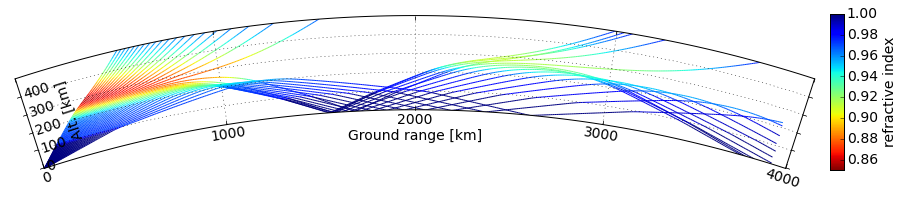

In [7]:
# Plot rays with refractive index color scale
# Plot 1 ray in 10 (1deg increment)
# Plot at start time
figure(figsize=(15,5))
rcParams.update({'font.size': 14})

ax, aax, cbax = rto.rays.plot(sTime, step=10, showrefract=True, nr_lim=[.85,1], maxground=maxground)

ax.grid()

In [8]:
# Read electron densities into memory
rto.readEdens()

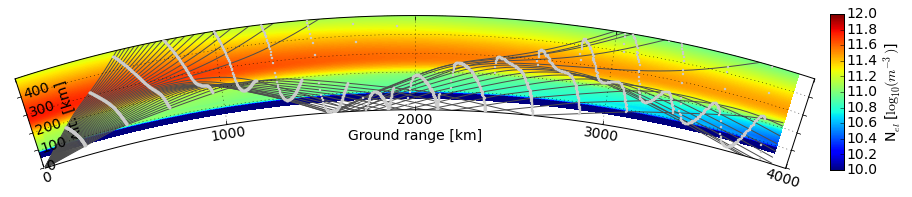

In [9]:
# Plot rays and electron densities together
# Plot at start time
# Plot range markers (every 250 km)
figure(figsize=(15,5))
rcParams.update({'font.size': 14})

ax, aax, cbax = rto.ionos.plot(sTime, maxground=maxground)
ax, aax, cbax = rto.rays.plot(sTime, 
    step=10, ax=ax, aax=aax, maxground=maxground)
rto.rays.showRange()

ax.grid()

In [10]:
# Read ionospheric and ground scatter into memory
rto.readScatter()

In [11]:
rto.rays.writeToAscii(os.path.join(home_dir,'Desktop/rays.txt'))

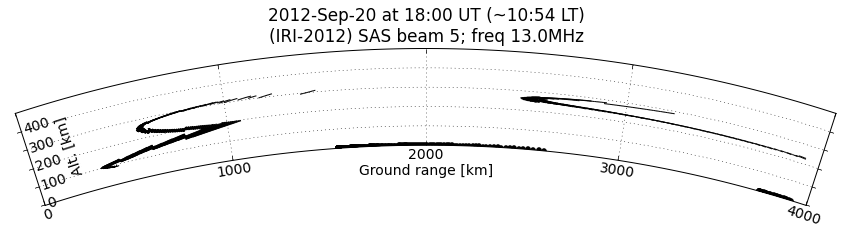

In [12]:
# Plot ionospheric and ground scatter together
# Plot at start time
# Plot relative strength of ionospheric scatter
figure(figsize=(15,5))
rcParams.update({'font.size': 14})

ax, aax, cax = rto.scatter.plot(sTime, title=True, weighted=False, maxground=maxground)

ax.grid()

In [13]:
rto.scatter.isc

{datetime.datetime(2012, 9, 20, 18, 0): {5: {11.0: {'gran': array([  405000.,   415000.,   425000.,   855000.,   865000.,   875000.,
             885000.,   895000.,   905000.,   915000.,   925000.,   935000.,
             945000.,   955000.,   965000.,   975000.,   985000.,   995000.,
            1005000.,  1015000.,  1025000.,  1035000.,  1045000.,  1055000.,
            1065000.,  1075000.,  1085000.,  1095000.,  1105000.,  1115000.]),
    'h': array([ 10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
            10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
            10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
            10000.,  10000.,  10000.,  10000.,  10000.,  10000.,  10000.,
            10000.,  10000.]),
    'lat': array([ 55.52394867,  55.60675049,  55.68947983,  59.21799469,
            59.29933548,  59.38063812,  59.46191788,  59.54315948,
            59.6243515 ,  59.70552063,  59.78665161,  59.8677597 ,
            59.94

In [14]:
kt = rto.scatter.isc.keys()[0]
kb = rto.scatter.isc[kt].keys()[0]


In [15]:
dict_list = []
for kt in rto.scatter.isc.keys():
    for kb in rto.scatter.isc[kt].keys():
        elv_dict = rto.scatter.isc[kt][kb]
        for key,value in elv_dict.items():
            for ii in range(value['nstp']):
                tmp_dict = {'time':kt,'beam':kb,'elv_init':key,'radar':radar}
                for param,param_val in value.items():
                    if param == 'nstp': continue
                    tmp_dict[param] = param_val[ii]
                dict_list.append(tmp_dict)

In [16]:
df = pandas.DataFrame(dict_list)

In [17]:
#The peak electron density of the F-region ionosphere undergoes significant variation 
#in the course of a day. This variation requires a minimum of two operating 
#frequencies: one for daytime operation and one for nighttime operation. A third
#intermediate frequency might also be desirable for the dawn and dusk transitions. One
#can assure similar propagagion conditions, if the ground scatter footprint of a 
# signal at a specific initial elevation angle remains at  a similiar great circle
#distance. The equations below are used to identify the local time of the UT time that
#is being processed. The minimum ionospheric electron density occurs 1-2 hours before 
#local dawn, while the maximum density occurs a few hours afer local noon.

hysteresis = 2.
df['Loc_time'] = (df['time'][0].hour + df['time'][0].minute/60. + df['lon']/15. - hysteresis) % 24.

In [18]:
del df['w']

In [19]:
df.tail()

,beam,elv_init,gran,h,lat,lon,nr,r,radar,rel,th,time,Loc_time
2871,5,19.6,2802362.25,10000,74.241684,-92.600739,0.923501,6628635.0,sas,2.438672,0.400176,2012-09-20 18:00:00,9.826617
2872,5,19.6,2812362.25,10000,74.318405,-92.524696,0.923389,6629524.0,sas,2.163429,0.401568,2012-09-20 18:00:00,9.831687
2873,5,19.6,2822362.25,10000,74.395126,-92.448288,0.923313,6630205.0,sas,1.893970,0.402960,2012-09-20 18:00:00,9.836781
2874,5,19.6,2832362.25,10000,74.471848,-92.371506,0.923269,6630667.5,sas,1.627419,0.404353,2012-09-20 18:00:00,9.841900
2875,5,19.6,2842362.25,10000,74.548584,-92.294350,0.923256,6630908.5,sas,1.363768,0.405745,2012-09-20 18:00:00,9.847043


In [20]:
#rto.scatter.gsc

In [21]:
#This code creates an additional dictionary list and DataFrame that identifies the elevation
#angles of all rays that are reflected by the ionosphere and backscattered by the ground.
#Knowledge of the highest elevation angle ground-backscattered ray greatly simplifies the 
#estimation of the refractive indices and great-circle distances to the scatter volumes.
#Currently the ray tracing codes examines propagation of rays reflected by the ionosphere out
#to the second ground intercept. This allows the 2-P geolocation analysis to estimate 
#the ground great-circle distances to both 1/2 hop and 1 1/2 hop ionospheric scatter locations
#as well as the refractive index of the scatter volumes. Typical predictions are available out
#available out to ranges of 3500-4000 km.

dict_list_gs = []
for kt in rto.scatter.gsc.keys():
    for kb in rto.scatter.gsc[kt].keys():
        elv_dict_gs = rto.scatter.gsc[kt][kb]
        for key,value in elv_dict_gs.items():
            for ii in range(1):
                tmp_dict_gs = {'time': kt,'beam': kb,'elv_init': key, 'radar': radar}
                for param,param_val in value.items():
                    if param == 1: continue
                    tmp_dict_gs[param] = param_val[ii]
                dict_list_gs.append(tmp_dict_gs)
                             

In [22]:
dgs = pandas.DataFrame(dict_list_gs)

In [23]:
#Local time in dgs DataFrame.
hysteresis = 2.
dgs['Loc_time'] = (dgs['time'][0].hour + dgs['time'][0].minute/60. + dgs['lon']/15. - hysteresis) % 24.

In [24]:
dgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 10 columns):
beam        145 non-null int64
elv_init    145 non-null float64
gran        145 non-null float64
lat         145 non-null float64
lon         145 non-null float64
r           145 non-null float64
radar       145 non-null object
th          145 non-null float64
time        145 non-null datetime64[ns]
Loc_time    145 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 12.5+ KB


In [25]:
dgs.head()

,beam,elv_init,gran,lat,lon,r,radar,th,time,Loc_time
0,5,11.5,2612173.50,73.672615,-93.149094,6577948.5,sas,0.389587,2012-09-20 18:00:00,9.790060
1,5,12.5,2407211.50,71.898010,-94.760376,6580990.5,sas,0.357372,2012-09-20 18:00:00,9.682642
2,5,22.6,1739809.75,65.595734,-99.459679,6619966.0,sas,0.242692,2012-09-20 18:00:00,9.369355
3,5,24.3,1806318.00,65.920029,-99.248047,6630803.5,sas,0.248449,2012-09-20 18:00:00,9.383464
4,5,13.5,2253728.75,70.555649,-95.880630,6584122.0,sas,0.332997,2012-09-20 18:00:00,9.607958


In [26]:
size_dgs = dgs.size
print size_dgs

1450


In [27]:
#The two-parameter analysis runs from the highest elevation-angle ray that detects scatter to the
#lowest. To accomplish this, both the df and dgs DataFrames need to be re-sorted and reindexed to run
#from high to low elevation angles. The re-sorted rays can be classified into three groups.
#Group 1:Rays that refract sufficiently to be backscattered and then quickly penetrate the ionosphere.
#Group 2: Rays that backscatter below the peak of the F-region and again above the peak of the F-layer
#after which they penetrate the ionosphere. Group 3: Rays that backscatter below the peak of the F-layer
#and then are reflected by the ionosphere. Each group is processed by its associated phase of the
#analysis.

if size_dgs != 0:
    dgs.sort('elv_init', ascending=False, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [28]:
if size_dgs != 0:
    dgs.reset_index(drop=True, inplace=True)

In [29]:
#Enter ionospheric tilt in degrees. Values can be positive, zero, or negative. Zero tilt means that the 
#ionosphere is horizontally stratified. Positive tilt means that the height of a constant electron 
# density surface increases with increasing range. Warning: Use tilts of approximately 1 degree and check
#consistency between great_circle distances predicted by ray tracing and 2-P method. If there is a
# tilt, the initial elevation angle after the ground reflection will change. The ionospheric tilt will most
# likely change with local time. It can also change sign.

tlt = 1.34



In [30]:
dgs['lgc_gs_rt'] = dgs['th'] * Re 
dgs['height_refl'] = dgs['r']*1e-3 - Re
dgs['h_gs_2p'] = np.sqrt(Re**2+((dgs['gran']*1e-3/2)**2)+((dgs['gran']*1e-3)*Re*np.sin(dgs['elv_init']*np.pi/180.)))\
   -Re 

In [31]:
tmp = []
for index,row in dgs.iterrows():
    h_gs_2p_max = 500. + 50*np.cos(row['Loc_time']*np.pi/12.) #Virtual height of peak limited.
    if row['h_gs_2p'] > h_gs_2p_max:
        row['h_gs_2p'] = h_gs_2p_max
    tmp.append(row)    
dgs = pandas.DataFrame(tmp)
del tmp
dgs['h_gs_2p'].describe()

count    145.000000
mean     368.863699
std       29.927729
min      343.252621
25%      346.729892
50%      357.744070
75%      380.483401
max      460.967104
Name: h_gs_2p, dtype: float64

In [32]:
#Initial iteration with guess for l_up_gs_2p
dgs['l_up_gs_2p'] = dgs['gran']*1e-3/2 + 0.25*Re*tlt*np.pi/180.   #initial guess
dgs['th_up_gs_2p'] = np.arcsin(dgs['l_up_gs_2p']*np.cos(dgs['elv_init']*np.pi/180.) / (Re + dgs['h_gs_2p']))
dgs['beta_up_gs_2p'] = np.pi/2 - dgs['elv_init']*np.pi/180 - (dgs['th_up_gs_2p'])
dgs['beta_down_gs_2p'] = dgs['beta_up_gs_2p'] + 2*tlt*np.pi/180.
dgs['elv_down_gs_2p'] = np.arccos((Re + dgs['h_gs_2p'])*np.sin(dgs['beta_down_gs_2p'])/Re)*180/np.pi
dgs['th_down_gs_2p'] = np.pi/2 - dgs['elv_down_gs_2p']*np.pi/180. - dgs['beta_down_gs_2p']
dgs['l_down_gs_2p'] = Re*np.sin(dgs['th_down_gs_2p'])/np.sin(dgs['beta_down_gs_2p'])
a=dgs['elv_down_gs_2p'][125]

#dgs['th_up_gs_2p'] = np.arcsin(dgs['l_up_gs_2p']*np.cos(dgs['elv_init']*np.pi/180.) / (Re + dgs['h_gs_2p']))
#dgs['beta_up_gs_2p'] = np.pi/2 - dgs['elv_init']*np.pi/180 - (dgs['th_up_gs_2p'])
#dgs['beta_down_gs_2p'] = dgs['beta_up_gs_2p'] + 2*tlt*np.pi/180.
#dgs['elv_down_gs_2p'] = np.arccos((Re + dgs['h_gs_2p'])*np.sin(dgs['beta_down_gs_2p'])/Re)*180/np.pi
#dgs['th_down_gs_2p'] = np.pi/2 - dgs['elv_down_gs_2p']*np.pi/180. - dgs['beta_down_gs_2p']
#dgs['l_down_gs_2p'] = Re*np.sin(dgs['th_down_gs_2p'])/np.sin(dgs['beta_down_gs_2p'])

#2nd iteration
dgs['ratio'] = dgs['gran']*1e-3/(dgs['l_up_gs_2p'] + dgs['l_down_gs_2p'])
dgs['l_up_gs_2p'] = dgs['l_up_gs_2p']*dgs['ratio']
dgs['h_gs_2p'] = np.sqrt(Re**2 + dgs['l_up_gs_2p']**2+2*dgs['l_up_gs_2p']*Re*np.sin(dgs['elv_init']*np.pi/180.)) - Re
dgs['th_up_gs_2p'] = np.arcsin(((dgs['l_up_gs_2p'])*np.cos(dgs['elv_init']*np.pi/180.)/(Re + dgs['h_gs_2p'])))
dgs['beta_up_gs_2p'] = np.pi/2 - dgs['elv_init']*np.pi/180 - (dgs['th_up_gs_2p'])
dgs['beta_down_gs_2p'] = dgs['beta_up_gs_2p'] + 2*tlt*np.pi/180.
dgs['elv_down_gs_2p'] = np.arccos((Re + dgs['h_gs_2p'])*np.sin(dgs['beta_down_gs_2p'])/Re)*180./np.pi
dgs['th_down_gs_2p'] = np.pi/2 - dgs['elv_down_gs_2p']*np.pi/180. - dgs['beta_down_gs_2p']
dgs['l_down_gs_2p'] = Re*np.sin(dgs['th_down_gs_2p'])/np.sin(dgs['beta_down_gs_2p']) 
dgs['lgc_gs_2p'] = (dgs['th_up_gs_2p'] + dgs['th_down_gs_2p'])*Re
dgs['th_gs_2p'] = dgs['th_up_gs_2p'] + dgs['th_down_gs_2p']
dgs['l_2p_pred'] = dgs['l_up_gs_2p'] + dgs['l_down_gs_2p']
b=dgs['elv_down_gs_2p'][125]
#3rd iteration
dgs['ratio'] = dgs['gran']*1e-3/(dgs['l_up_gs_2p'] + dgs['l_down_gs_2p'])
dgs['l_up_gs_2p'] = dgs['l_up_gs_2p']*dgs['ratio']
dgs['h_gs_2p'] = np.sqrt(Re**2 + dgs['l_up_gs_2p']**2+2*dgs['l_up_gs_2p']*Re*np.sin(dgs['elv_init']*np.pi/180.)) - Re
dgs['th_up_gs_2p'] = np.arcsin(((dgs['l_up_gs_2p'])*np.cos(dgs['elv_init']*np.pi/180.)/(Re + dgs['h_gs_2p'])))
dgs['beta_up_gs_2p'] = np.pi/2 - dgs['elv_init']*np.pi/180 - (dgs['th_up_gs_2p'])
dgs['beta_down_gs_2p'] = dgs['beta_up_gs_2p'] + 2*tlt*np.pi/180.
dgs['elv_down_gs_2p'] = np.arccos((Re + dgs['h_gs_2p'])*np.sin(dgs['beta_down_gs_2p'])/Re)*180/np.pi
dgs['th_down_gs_2p'] = np.pi/2 - dgs['elv_down_gs_2p']*np.pi/180. - dgs['beta_down_gs_2p']
dgs['l_down_gs_2p'] = Re*np.sin(dgs['th_down_gs_2p'])/np.sin(dgs['beta_down_gs_2p']) 
dgs['lgc_gs_2p'] = (dgs['th_up_gs_2p'] + dgs['th_down_gs_2p'])*Re
dgs['th_gs_2p'] = dgs['th_up_gs_2p'] + dgs['th_down_gs_2p']
dgs['l_2p_pred'] = dgs['l_up_gs_2p'] + dgs['l_down_gs_2p']
c=dgs['elv_down_gs_2p'][125]
#4th iteration
dgs['ratio'] = dgs['gran']*1e-3/(dgs['l_up_gs_2p'] + dgs['l_down_gs_2p'])
dgs['l_up_gs_2p'] = dgs['l_up_gs_2p']*dgs['ratio']
dgs['h_gs_2p'] = np.sqrt(Re**2 + dgs['l_up_gs_2p']**2+2*dgs['l_up_gs_2p']*Re*np.sin(dgs['elv_init']*np.pi/180.)) - Re
dgs['th_up_gs_2p'] = np.arcsin(((dgs['l_up_gs_2p'])*np.cos(dgs['elv_init']*np.pi/180.)/(Re + dgs['h_gs_2p'])))
dgs['beta_up_gs_2p'] = np.pi/2 - dgs['elv_init']*np.pi/180 - (dgs['th_up_gs_2p'])
dgs['beta_down_gs_2p'] = dgs['beta_up_gs_2p'] + 2*tlt*np.pi/180.
dgs['elv_down_gs_2p'] = np.arccos((Re + dgs['h_gs_2p'])*np.sin(dgs['beta_down_gs_2p'])/Re)*180/np.pi
dgs['th_down_gs_2p'] = np.pi/2 - dgs['elv_down_gs_2p']*np.pi/180.- dgs['beta_down_gs_2p']
dgs['l_down_gs_2p'] = Re*np.sin(dgs['th_down_gs_2p'])/np.sin(dgs['beta_down_gs_2p']) 
dgs['lgc_gs_2p'] = (dgs['th_up_gs_2p'] + dgs['th_down_gs_2p'])*Re
dgs['th_gs_2p'] = dgs['th_up_gs_2p'] + dgs['th_down_gs_2p']
dgs['l_2p_pred'] = dgs['l_up_gs_2p'] + dgs['l_down_gs_2p']
d=dgs['elv_down_gs_2p'][125]
print a,b,c,d

7.80736648826 7.30454791132 7.43401754976 7.43077050303


In [33]:
gs_list = ['th_gs_2p', 'elv_init',  'elv_down_gs_2p', 'lgc_gs_rt', 'lgc_gs_2p', 'h_gs_2p', 'l_up_gs_2p',\
          'l_down_gs_2p', 'th_down_gs_2p', 'beta_down_gs_2p']
dgs[gs_list].tail(-110)

,th_gs_2p,elv_init,elv_down_gs_2p,lgc_gs_rt,lgc_gs_2p,h_gs_2p,l_up_gs_2p,l_down_gs_2p,th_down_gs_2p,beta_down_gs_2p
110,0.315623,14.4,9.547180,2008.430278,2010.834763,301.324920,953.432926,1189.833400,0.176773,1.227394
111,0.317463,14.3,9.414447,2020.223141,2022.556767,301.260191,957.323391,1197.387595,0.177979,1.228505
112,0.319287,14.2,9.281141,2031.847208,2034.179583,301.148568,961.118936,1204.911581,0.179181,1.229628
113,0.321145,14.1,9.146839,2043.697982,2046.015698,301.047028,964.969816,1212.601875,0.180410,1.230744
114,0.323096,14.0,9.011008,2056.183872,2058.445966,301.023763,969.057749,1220.698541,0.181698,1.231827
115,0.324960,13.9,8.875098,2068.016418,2070.323050,300.868901,972.825345,1228.485705,0.182943,1.232953
116,0.327040,13.8,8.736540,2081.367169,2083.572745,300.930134,977.199144,1237.171171,0.184320,1.233995
117,0.329027,13.7,8.597879,2094.009133,2096.230646,300.851151,981.229348,1245.526692,0.185650,1.235085
118,0.331157,13.6,8.457054,2107.649626,2109.799585,300.900614,985.634956,1254.497121,0.187072,1.236121
119,0.333325,13.5,8.314898,2121.522711,2123.612407,300.956975,990.091563,1263.666877,0.188524,1.237150


In [34]:
dgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 24 columns):
beam               145 non-null int64
elv_init           145 non-null float64
gran               145 non-null float64
lat                145 non-null float64
lon                145 non-null float64
r                  145 non-null float64
radar              145 non-null object
th                 145 non-null float64
time               145 non-null datetime64[ns]
Loc_time           145 non-null float64
lgc_gs_rt          145 non-null float64
height_refl        145 non-null float64
h_gs_2p            145 non-null float64
l_up_gs_2p         145 non-null float64
th_up_gs_2p        145 non-null float64
beta_up_gs_2p      145 non-null float64
beta_down_gs_2p    145 non-null float64
elv_down_gs_2p     145 non-null float64
th_down_gs_2p      145 non-null float64
l_down_gs_2p       145 non-null float64
ratio              145 non-null float64
lgc_gs_2p          145 non-null float64
th_gs_2p   

In [35]:
dgs.tail(-30)

,beam,elv_init,gran,lat,lon,r,radar,th,time,Loc_time,...,th_up_gs_2p,beta_up_gs_2p,beta_down_gs_2p,elv_down_gs_2p,th_down_gs_2p,l_down_gs_2p,ratio,lgc_gs_2p,th_gs_2p,l_2p_pred
30,5,22.4,1738397.500,65.606720,-99.452461,6618791.0,sas,0.242904,2012-09-20 18:00:00,9.369836,...,0.112290,1.067552,1.114327,18.677927,0.130478,923.466767,1.000057,1546.674273,0.242768,1738.397689
31,5,22.3,1738588.250,65.616562,-99.446167,6618397.5,sas,0.243085,2012-09-20 18:00:00,9.370256,...,0.112365,1.069223,1.115998,18.572807,0.130642,923.865221,1.000058,1548.196401,0.243007,1738.588445
32,5,22.2,1738161.375,65.624367,-99.441200,6617798.0,sas,0.243233,2012-09-20 18:00:00,9.370587,...,0.112401,1.070932,1.117707,18.468017,0.130762,923.937821,1.000059,1549.192063,0.243163,1738.161576
33,5,22.1,1738436.000,65.637085,-99.432785,6617258.0,sas,0.243472,2012-09-20 18:00:00,9.371148,...,0.112480,1.072599,1.119374,18.362738,0.130932,924.386911,1.000060,1550.777942,0.243412,1738.436208
34,5,22.0,1738863.375,65.649643,-99.424622,6616803.5,sas,0.243704,2012-09-20 18:00:00,9.371692,...,0.112567,1.074257,1.121032,18.257307,0.131114,924.920537,1.000062,1552.490207,0.243681,1738.863590
35,5,21.9,1739638.375,65.665932,-99.414078,6616308.0,sas,0.244005,2012-09-20 18:00:00,9.372395,...,0.112674,1.075895,1.122670,18.151599,0.131321,925.642713,1.000063,1554.494829,0.243995,1739.638598
36,5,21.8,1740105.750,65.679871,-99.405098,6615793.0,sas,0.244260,2012-09-20 18:00:00,9.372993,...,0.112762,1.077552,1.124327,18.046024,0.131507,926.204291,1.000064,1556.235449,0.244269,1740.105980
37,5,21.7,1741131.375,65.697319,-99.393570,6615334.0,sas,0.244585,2012-09-20 18:00:00,9.373762,...,0.112883,1.079176,1.125951,17.940033,0.131732,927.067036,1.000065,1558.448410,0.244616,1741.131614
38,5,21.6,1742160.875,65.714767,-99.382141,6614876.5,sas,0.244908,2012-09-20 18:00:00,9.374524,...,0.113004,1.080801,1.127576,17.833974,0.131959,927.935502,1.000066,1560.662718,0.244964,1742.161122
39,5,21.5,1743131.250,65.732773,-99.370392,6614354.0,sas,0.245240,2012-09-20 18:00:00,9.375307,...,0.113121,1.082430,1.129204,17.727886,0.132182,928.776120,1.000067,1562.824635,0.245303,1743.131506


In [36]:
see=['elv_init','height_refl','h_gs_2p']
dgs[see].tail(-100)

,elv_init,height_refl,h_gs_2p
100,15.4,219.3660,303.102243
101,15.3,219.0340,302.916035
102,15.2,218.6620,302.624619
103,15.1,218.3470,302.483819
104,15.0,217.9585,302.211941
105,14.9,217.6380,302.167764
106,14.8,217.3715,301.862783
107,14.7,216.9860,301.743394
108,14.6,216.6905,301.607721
109,14.5,216.3235,301.458429


In [37]:
#Sort df by elv_init and gran so that it runs from highest to lowest elevation angles and then by 
#increasing group range. This is done before beginning the 2-Parmeter analysis. In order to carry out
#the analysis for 1 1/2 hop backscatter, we also need to determine the great circle distance to the 1-hop
#ground scatter location and decrease gran by the group range required to reach the ground scatter location
#for each elevation angle.

In [38]:
df.sort(['elv_init', 'gran'], ascending=[False, True], inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [39]:
df.reset_index(drop=True, inplace=True)

In [40]:
df['lgc_gs_2p'] = np.zeros_like(df['r'], dtype = np.float64)
df['gran_gs'] = np.zeros_like(df['gran'], dtype = np.float64)
df['2nd_elv_init'] = np.zeros_like(df['elv_init'], dtype = np.float64)

In [41]:
df.tail(-3240)

,beam,elv_init,gran,h,lat,lon,nr,r,radar,rel,th,time,Loc_time,lgc_gs_2p,gran_gs,2nd_elv_init


In [42]:
dgs['gran_gs'] = np.zeros_like(dgs['gran'], dtype = np.float64)
dgs['gran_gs'] = dgs['gran']
dgs.tail(-50)

,beam,elv_init,gran,lat,lon,r,radar,th,time,Loc_time,...,beta_up_gs_2p,beta_down_gs_2p,elv_down_gs_2p,th_down_gs_2p,l_down_gs_2p,ratio,lgc_gs_2p,th_gs_2p,l_2p_pred,gran_gs
50,5,20.4,1765308.875,66.012802,-99.186958,6609345.0,sas,0.250369,2012-09-20 18:00:00,9.387536,...,1.099688,1.146463,16.548358,0.135510,944.453871,1.000083,1596.386016,0.250571,1765.309265,1765308.875
51,5,20.3,1767890.875,66.041206,-99.168022,6608993.0,sas,0.250891,2012-09-20 18:00:00,9.388799,...,1.101227,1.148002,16.440228,0.135858,946.211326,1.000085,1599.922856,0.251126,1767.891281,1767890.875
52,5,20.2,1770890.750,66.074890,-99.145752,6608532.5,sas,0.251508,2012-09-20 18:00:00,9.390283,...,1.102741,1.149516,16.331713,0.136239,948.198478,1.000087,1603.820952,0.251738,1770.891173,1770890.750
53,5,20.1,1773940.250,66.108589,-99.123390,6608104.5,sas,0.252122,2012-09-20 18:00:00,9.391774,...,1.104252,1.151027,16.223061,0.136623,950.217996,1.000089,1607.763020,0.252356,1773.940691,1773940.250
54,5,20.0,1776877.250,66.140503,-99.102341,6607723.5,sas,0.252705,2012-09-20 18:00:00,9.393177,...,1.105771,1.152546,16.114384,0.137001,952.182930,1.000091,1611.608943,0.252960,1776.877710,1776877.250
55,5,19.9,1780020.000,66.174782,-99.079376,6607188.0,sas,0.253333,2012-09-20 18:00:00,9.394708,...,1.107279,1.154054,16.005458,0.137395,954.264347,1.000092,1615.633946,0.253592,1780.020480,1780020.000
56,5,19.8,1783400.000,66.210617,-99.055672,6606797.0,sas,0.253989,2012-09-20 18:00:00,9.396289,...,1.108772,1.155547,15.896254,0.137807,956.479452,1.000094,1619.865771,0.254256,1783.400501,1783400.000
57,5,19.7,1786862.375,66.247330,-99.031296,6606394.5,sas,0.254660,2012-09-20 18:00:00,9.397914,...,1.110262,1.157036,15.786878,0.138227,958.745227,1.000097,1624.170637,0.254932,1786.862898,1786862.375
58,5,19.6,1790237.500,66.283051,-99.007523,6606012.5,sas,0.255309,2012-09-20 18:00:00,9.399498,...,1.111757,1.158532,15.677449,0.138641,960.970562,1.000099,1628.401516,0.255596,1790.238047,1790237.500
59,5,19.5,1793769.750,66.320099,-98.982742,6605608.0,sas,0.255987,2012-09-20 18:00:00,9.401151,...,1.113244,1.160019,15.567790,0.139068,963.287106,1.000101,1632.770456,0.256282,1793.770321,1793769.750


In [43]:
#The next step is to calculate the pseudo-radar locations for 1-1/2-hop scatter modes. Effectively, we
#determine the geographical locations and bearings of the radar transmissions at the 1-hop ground-scatter
#locations. This information along with the gran, lgc_2p, and elv_down_gs_2p values from the dgs dataframe
#will be copied into a new dataframe df2 that will be used to determine the 1-1/2-hop scatter locations.



In [44]:
df['elv_init'].describe()

count    2876.000000
mean       17.192872
std         5.201084
min        11.000000
25%        12.900000
50%        15.200000
75%        20.800000
max        28.700000
Name: elv_init, dtype: float64

In [45]:
lgc_gs_2p = np.zeros([len(df)], dtype=np.float)
gran_gs = np.zeros([len(df)], dtype=np.float)
scnd_elv_init = np.zeros([len(df)], dtype=np.float)
elv_init = np.zeros([len(df)], dtype=np.float)
curr_elev_init = np.zeros([len(dgs)], dtype=np.float)
elv_down_gs_2p = np.zeros([len(dgs)], dtype=np.float)
radar_offset = np.zeros([len(dgs)], dtype=np.float)
gran_gs_loc = np.zeros([len(dgs)], dtype=np.float)

elv_init = df['elv_init']
curr_elv_init = dgs['elv_init']
gs_loc_elv_init = dgs['elv_down_gs_2p']
radar_offset = dgs['lgc_gs_2p']
gran_gs_loc = dgs['gran_gs']
index = 0
index1 = 0

while index < len(df):
    
    if curr_elv_init[index1] < elv_init[index]:
        scnd_elv_init[index] = 0.0
        lgc_gs_2p[index] = 10000.0
        gran_gs[index] = 10000000.0

    elif curr_elv_init[index1] == elv_init[index]:
        scnd_elv_init[index] = gs_loc_elv_init[index1]
        lgc_gs_2p[index] = radar_offset[index1]
        gran_gs[index] = gran_gs_loc[index1]

    elif curr_elv_init[index1] > elv_init[index]:
        index1 = index1 + 1
        scnd_elv_init[index] = gs_loc_elv_init[index1]
        lgc_gs_2p[index] = radar_offset[index1]
        gran_gs[index] = gran_gs_loc[index1]
        
    #print index, index1, elv_init[index], curr_elv_init[index1]
    index = index + 1
df['lgc_gs_2p'] = lgc_gs_2p
df['gran_gs'] = gran_gs
df['2nd_elv_init'] = scnd_elv_init


In [46]:
#The peak electron density of the F-region ionosphere undergoes significant variation 
#in the course of a day. This variation requires a minimum of two operating 
#frequencies: one for daytime operation and one for nighttime operation. A third
#intermediate frequency might also be desirable for the dawn and dusk transitions. One
#can assure similar propagagion conditions, if the ground scatter footprint of a 
# signal at a specific initial elevation angle remains at  a similiar great circle
#distance. The equations below are used to identify the local time of the UT time that
#is being processed. The minimum ionospheric electron density occurs 1-2 hours before 
#local dawn, while the maximum density occurs a few hours afer local noon.

hysteresis = 2.
df['Loc_time'] = (df['time'][0].hour + df['time'][0].minute/60. + df['lon']/15. - hysteresis) % 24.

In [47]:
df['lgc_rt']=df['th'] * Re

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 2875
Data columns (total 17 columns):
beam            2876 non-null int64
elv_init        2876 non-null float64
gran            2876 non-null float64
h               2876 non-null float64
lat             2876 non-null float64
lon             2876 non-null float64
nr              2876 non-null float64
r               2876 non-null float64
radar           2876 non-null object
rel             2876 non-null float64
th              2876 non-null float64
time            2876 non-null datetime64[ns]
Loc_time        2876 non-null float64
lgc_gs_2p       2876 non-null float64
gran_gs         2876 non-null float64
2nd_elv_init    2876 non-null float64
lgc_rt          2876 non-null float64
dtypes: datetime64[ns](1), float64(14), int64(1), object(1)
memory usage: 404.4+ KB


In [49]:
#df.head(64)

In [50]:
df['height']=df['r']/1000.-Re

In [51]:
df.tail(-850)

,beam,elv_init,gran,h,lat,lon,nr,r,radar,rel,th,time,Loc_time,lgc_gs_2p,gran_gs,2nd_elv_init,lgc_rt,height
850,5,20.2,2840344.50,10000,74.438965,-92.404610,0.920084,6635956.0,sas,1.529979,0.403710,2012-09-20 18:00:00,9.839693,1603.820952,1770890.75,16.331713,2572.037598,264.9560
851,5,20.2,2850344.50,10000,74.515366,-92.327934,0.920100,6636157.0,sas,1.326516,0.405097,2012-09-20 18:00:00,9.844804,1603.820952,1770890.75,16.331713,2580.870758,265.1570
852,5,20.1,695000.00,10000,57.598495,-103.997185,0.928735,6589119.5,sas,10.789423,0.098881,2012-09-20 18:00:00,9.066854,1607.763020,1773940.25,16.223061,629.972695,218.1195
853,5,20.1,705000.00,10000,57.674946,-103.958954,0.926466,6591834.0,sas,10.125216,0.100263,2012-09-20 18:00:00,9.069403,1607.763020,1773940.25,16.223061,638.772437,220.8340
854,5,20.1,715000.00,10000,57.751350,-103.920670,0.924347,6595123.0,sas,9.459476,0.101643,2012-09-20 18:00:00,9.071955,1607.763020,1773940.25,16.223061,647.568905,224.1230
855,5,20.1,2738940.25,10000,73.678543,-93.147926,0.921759,6626053.0,sas,3.904865,0.389921,2012-09-20 18:00:00,9.790138,1607.763020,1773940.25,16.223061,2484.187132,255.0530
856,5,20.1,2748940.25,10000,73.755005,-93.074707,0.921490,6627272.5,sas,3.640731,0.391308,2012-09-20 18:00:00,9.795020,1607.763020,1773940.25,16.223061,2493.023709,256.2725
857,5,20.1,2758940.25,10000,73.831459,-93.001152,0.921261,6628514.0,sas,3.382415,0.392695,2012-09-20 18:00:00,9.799923,1607.763020,1773940.25,16.223061,2501.859907,257.5140
858,5,20.1,2768940.25,10000,73.907898,-92.927269,0.921065,6629736.0,sas,3.129906,0.394082,2012-09-20 18:00:00,9.804849,1607.763020,1773940.25,16.223061,2510.695725,258.7360
859,5,20.1,2778940.25,10000,73.984352,-92.853050,0.920902,6630891.5,sas,2.886063,0.395469,2012-09-20 18:00:00,9.809797,1607.763020,1773940.25,16.223061,2519.531543,259.8915


In [52]:
df.tail(-2800)  

,beam,elv_init,gran,h,lat,lon,nr,r,radar,rel,th,time,Loc_time,lgc_gs_2p,gran_gs,2nd_elv_init,lgc_rt,height
2800,5,11.2,1025000,10000,60.586868,-102.437027,0.969103,6554107.0,sas,9.099532,0.153169,2012-09-20 18:00:00,9.170865,2559.587252,2687674.00,4.335580,975.837270,183.1070
2801,5,11.2,1035000,10000,60.667480,-102.393005,0.968832,6555771.0,sas,9.067618,0.154627,2012-09-20 18:00:00,9.173800,2559.587252,2687674.00,4.335580,985.129347,184.7710
2802,5,11.2,1045000,10000,60.748074,-102.348900,0.968529,6557455.0,sas,9.024105,0.156085,2012-09-20 18:00:00,9.176740,2559.587252,2687674.00,4.335580,994.417626,186.4550
2803,5,11.2,1055000,10000,60.828602,-102.304695,0.968173,6559175.0,sas,8.960296,0.157542,2012-09-20 18:00:00,9.179687,2559.587252,2687674.00,4.335580,1003.702109,188.1750
2804,5,11.2,1065000,10000,60.909111,-102.260406,0.967745,6560935.5,sas,8.870401,0.158999,2012-09-20 18:00:00,9.182640,2559.587252,2687674.00,4.335580,1012.982983,189.9355
2805,5,11.2,1075000,10000,60.989578,-102.216019,0.967168,6562778.0,sas,8.725457,0.160455,2012-09-20 18:00:00,9.185599,2559.587252,2687674.00,4.335580,1022.260535,191.7780
2806,5,11.2,1085000,10000,61.070007,-102.171547,0.966204,6564765.0,sas,8.447319,0.161911,2012-09-20 18:00:00,9.188564,2559.587252,2687674.00,4.335580,1031.535429,193.7650
2807,5,11.2,1095000,10000,61.150406,-102.126968,0.965006,6566624.0,sas,8.042059,0.163366,2012-09-20 18:00:00,9.191535,2559.587252,2687674.00,4.335580,1040.807855,195.6240
2808,5,11.2,1105000,10000,61.230762,-102.082298,0.963852,6568003.0,sas,7.614081,0.164821,2012-09-20 18:00:00,9.194513,2559.587252,2687674.00,4.335580,1050.077242,197.0030
2809,5,11.2,4082674,10000,85.800430,-72.090324,0.961995,6604127.5,sas,1.085820,0.610485,2012-09-20 18:00:00,11.193978,2559.587252,2687674.00,4.335580,3889.397387,233.1275


In [53]:
df.tail(-850)

,beam,elv_init,gran,h,lat,lon,nr,r,radar,rel,th,time,Loc_time,lgc_gs_2p,gran_gs,2nd_elv_init,lgc_rt,height
850,5,20.2,2840344.50,10000,74.438965,-92.404610,0.920084,6635956.0,sas,1.529979,0.403710,2012-09-20 18:00:00,9.839693,1603.820952,1770890.75,16.331713,2572.037598,264.9560
851,5,20.2,2850344.50,10000,74.515366,-92.327934,0.920100,6636157.0,sas,1.326516,0.405097,2012-09-20 18:00:00,9.844804,1603.820952,1770890.75,16.331713,2580.870758,265.1570
852,5,20.1,695000.00,10000,57.598495,-103.997185,0.928735,6589119.5,sas,10.789423,0.098881,2012-09-20 18:00:00,9.066854,1607.763020,1773940.25,16.223061,629.972695,218.1195
853,5,20.1,705000.00,10000,57.674946,-103.958954,0.926466,6591834.0,sas,10.125216,0.100263,2012-09-20 18:00:00,9.069403,1607.763020,1773940.25,16.223061,638.772437,220.8340
854,5,20.1,715000.00,10000,57.751350,-103.920670,0.924347,6595123.0,sas,9.459476,0.101643,2012-09-20 18:00:00,9.071955,1607.763020,1773940.25,16.223061,647.568905,224.1230
855,5,20.1,2738940.25,10000,73.678543,-93.147926,0.921759,6626053.0,sas,3.904865,0.389921,2012-09-20 18:00:00,9.790138,1607.763020,1773940.25,16.223061,2484.187132,255.0530
856,5,20.1,2748940.25,10000,73.755005,-93.074707,0.921490,6627272.5,sas,3.640731,0.391308,2012-09-20 18:00:00,9.795020,1607.763020,1773940.25,16.223061,2493.023709,256.2725
857,5,20.1,2758940.25,10000,73.831459,-93.001152,0.921261,6628514.0,sas,3.382415,0.392695,2012-09-20 18:00:00,9.799923,1607.763020,1773940.25,16.223061,2501.859907,257.5140
858,5,20.1,2768940.25,10000,73.907898,-92.927269,0.921065,6629736.0,sas,3.129906,0.394082,2012-09-20 18:00:00,9.804849,1607.763020,1773940.25,16.223061,2510.695725,258.7360
859,5,20.1,2778940.25,10000,73.984352,-92.853050,0.920902,6630891.5,sas,2.886063,0.395469,2012-09-20 18:00:00,9.809797,1607.763020,1773940.25,16.223061,2519.531543,259.8915


In [54]:
df['phase'] = np.zeros_like(df['beam'], dtype = np.int64)

In [55]:
# Determine the "phase" of the analysis.
#   Phase 1: Radar rays that eventually penetrate the ionosphere
#   Phase 2: Radar rays that eventually produce ground scatter.

phase_nr  = np.zeros([len(df)],dtype=np.int)

if size_dgs != 0:
    max_elv_init_gs = dgs['elv_init'][0]
    tf = np.array( df['elv_init'] <= max_elv_init_gs )
    phase_nr[tf] = 2
    phase_nr[phase_nr == 0] = 1
else: 
    phase_nr = 1
    max_elv_init_gs = 0.

df['phase'] = phase_nr

print df['elv_init'][0], max_elv_init_gs

28.7 25.4


In [56]:
df['scat_mode'] = np.zeros_like(df['elv_init'], dtype=np.float)
df['resid_gran'] = np.zeros_like(df['gran'], dtype=np.float)

#Determine whether ionospheric scatter mode is 1/2-hop or 1 1/2-hop and flag.
#Reduce gran by group range to ground scatter location

df['resid_gran'] = df['gran'] - df['gran_gs']

scat_hops  = np.zeros([len(df)],dtype=np.float)

if size_dgs != 0:
    tf = np.array( df['resid_gran'] > 0.0 )
    scat_hops[tf] = 1.5
    scat_hops[scat_hops == 0] = 0.5
else: 
    scat_hops = 0.5
    max_elv_init_gs = 0.

df['scat_mode'] = scat_hops

In [57]:
df.describe()

,beam,elv_init,gran,h,lat,lon,nr,r,rel,th,Loc_time,lgc_gs_2p,gran_gs,2nd_elv_init,lgc_rt,height,phase,scat_mode,resid_gran
count,2876,2876.000000,2876.000000,2876,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,5,17.192872,1412071.788769,10000,63.403311,-99.560510,0.941806,6576795.820063,8.008008,0.204077,9.362633,3100.926123,3225555.010648,9.209646,1300.174112,205.795820,1.862309,0.784771,-1813483.221879
std,0,5.201084,1103844.822603,0,8.852126,7.220564,0.033462,58989.046598,4.063050,0.160362,0.481371,2772.912682,2721699.555406,5.572933,1021.666403,58.989047,0.344636,0.451384,3164838.193214
min,5,11.000000,345000.000000,10000,54.954029,-105.271675,0.869081,6460447.000000,-0.550048,0.051261,8.981888,1543.521243,1738161.375000,0.000000,326.581412,89.447000,1.000000,0.500000,-9365000.000000
25%,5,12.900000,665000.000000,10000,57.259689,-104.165689,0.918718,6526769.375000,3.106236,0.092759,9.055621,1729.702137,1889487.500000,5.764924,590.970497,155.769375,2.000000,0.500000,-1706601.125000
50%,5,15.200000,835000.000000,10000,58.842493,-103.364025,0.953547,6586585.500000,9.731135,0.121417,9.109065,2083.572745,2214348.250000,8.736540,773.549730,215.585500,2.000000,0.500000,-1546829.125000
75%,5,20.800000,2790787.750000,10000,74.067505,-92.771931,0.971168,6624592.000000,10.906100,0.396988,9.815205,2393.546208,2521926.250000,13.582388,2529.213045,253.592000,2.000000,1.500000,1005000.000000
max,5,28.700000,4113956.500000,10000,86.051987,-71.132057,0.996064,6684987.000000,13.839328,0.615051,11.257863,10000.000000,10000000.000000,21.566240,3918.487081,313.987000,2.000000,1.500000,1845000.125000


In [58]:
see = ['elv_init', 'scat_mode', 'gran', 'gran_gs', 'height', 'lgc_gs_2p', 'resid_gran', 'phase']
df[see].tail(-540)



,elv_init,scat_mode,gran,gran_gs,height,lgc_gs_2p,resid_gran,phase
540,21.4,0.5,685000.0,1744288.125,225.9220,1565.143743,-1059288.125,2
541,21.4,0.5,695000.0,1744288.125,229.1795,1565.143743,-1049288.125,2
542,21.3,0.5,665000.0,1745939.500,221.2120,1567.883765,-1080939.500,2
543,21.3,0.5,685000.0,1745939.500,225.1345,1567.883765,-1060939.500,2
544,21.3,0.5,695000.0,1745939.500,228.3325,1567.883765,-1050939.500,2
545,21.3,1.5,2810939.5,1745939.500,271.7835,1567.883765,1065000.000,2
546,21.3,1.5,2820939.5,1745939.500,272.5365,1567.883765,1075000.000,2
547,21.3,1.5,2830939.5,1745939.500,273.2620,1567.883765,1085000.000,2
548,21.3,1.5,2840939.5,1745939.500,273.9595,1567.883765,1095000.000,2
549,21.3,1.5,2850939.5,1745939.500,274.6370,1567.883765,1105000.000,2


In [59]:
#Determination of 'h-2p' (virtual height) for 1/2 hop and 1 1/2 hop modes. This is done by using different parameters
#from the data frame df depending on whether 'scat_mode' is 0.5 or 1.5.
h_2p = np.zeros([len(df)],dtype=np.float)

for index,row in df.iterrows():
    if row['scat_mode'] == 0.5:
        h_2p[index] = np.sqrt(Re**2 + (row['gran']*1e-3)**2 + 2*(row['gran']*1e-3)*Re*np.sin(row['elv_init']*np.pi/180.)) - Re
    elif row['scat_mode'] == 1.5:
        h_2p[index] = np.sqrt(Re**2 + (row['resid_gran']*1e-3)**2 + 2*(row['resid_gran']*1e-3)*Re*np.sin(row['2nd_elv_init']*np.pi/180.)) - Re
    else:
        print 'incorrect value in column scat_mode of df'
        
df['h_2p'] = h_2p

#df['h_2p'] = np.sqrt(Re**2 + (df['gran']*1e-3)**2 + 2*(df['gran']*1e-3)*Re*np.sin(df['elv_init']*np.pi/180.)) - Re
df['h_2p'].describe()

count    2876.000000
mean      283.813228
std       118.705816
min        89.521475
25%       209.817219
50%       275.590207
75%       329.171629
max       892.656876
Name: h_2p, dtype: float64

In [60]:
see = ['scat_mode', 'gran', 'resid_gran', 'h_2p', 'elv_init', '2nd_elv_init']
df[see].tail(-1500)

,scat_mode,gran,resid_gran,h_2p,elv_init,2nd_elv_init
1500,0.5,825000.00,-1266292.625,260.235518,14.9,10.195435
1501,0.5,835000.00,-1256292.625,263.956545,14.9,10.195435
1502,0.5,845000.00,-1246292.625,267.690550,14.9,10.195435
1503,0.5,855000.00,-1236292.625,271.437510,14.9,10.195435
1504,1.5,3202755.75,1111463.125,287.213079,14.9,10.195435
1505,1.5,3212755.75,1121463.125,290.582756,14.9,10.195435
1506,1.5,3222755.75,1131463.125,293.965733,14.9,10.195435
1507,1.5,3232755.75,1141463.125,297.361990,14.9,10.195435
1508,1.5,3242755.75,1151463.125,300.771507,14.9,10.195435
1509,0.5,355000.00,-1745611.000,99.792215,14.8,10.068118


In [61]:
#The minimum height of the peak of the F-region electron density profile occurs a few hours
#after local noon and the maximum height occurs a few hours before dawn. EUV photons emitted
#by the sun is the principal process for creation of the ionosphere and 3-body recombination
#is the principal process for its decay. THe third body in the reaction is a neutral atom. Since
#the neutral density of the upper atmosphere decreases with altitude, the ionosphere after sunset
#decays from the bottom up. This equation is used in the 2-parameter analysis to mirror the change
#in height of the ionosphere over a day. The changes in virtual height affect the Earth-centered angle
#included by the group path and the initial elevation angle and ultimately impact the great-circle
#distance of the scattering volume. The expression below optimmizes the diurnal variation of the
#virtual height and great-circle distance.

tmp = []
for index,row in df.iterrows():
    h_2p_max = 500. + 50*np.cos(row['Loc_time']*np.pi/12.) 
    if row['h_2p'] > h_2p_max:
        row['h_2p'] = h_2p_max
    tmp.append(row)    
df = pandas.DataFrame(tmp)
del tmp
df['h_2p'].describe()


count    2876.000000
mean      275.142075
std        95.718064
min        89.521475
25%       209.817219
50%       275.590207
75%       329.171629
max       463.671592
Name: h_2p, dtype: float64

In [62]:
#Calculation of 'lgc_2p' for 1/2-hop and 1 1/2-hop scatter modes. This is done in two different ways
#depending on whether it is 1/2-hop or 1 1/2 hop.

th_2p = np.zeros([len(df)],dtype=np.float)
lgc_2p = np.zeros([len(df)],dtype=np.float)

for index,row in df.iterrows():
    if row['scat_mode'] == 0.5:
        th_2p[index]  = np.arcsin((row['gran']*1e-3)*np.cos(row['elv_init']*np.pi/180.) / (Re + row['h_2p']))
        lgc_2p[index] = th_2p[index] * Re 
    
    elif row['scat_mode'] == 1.5:
        th_2p[index]  = np.arcsin((row['resid_gran']*1e-3)*np.cos(row['2nd_elv_init']*np.pi/180.) / (Re + row['h_2p']))
        lgc_2p[index] = th_2p[index] * Re + row['lgc_gs_2p']
     
    else:
        print 'incorrect value in column scat_mode of df'
        
df['th_2p'] = th_2p
df['lgc_2p'] = lgc_2p


In [63]:
df['nr_2p'] = np.zeros_like(df['th_2p'], dtype=np.float)
size = df['th_2p'].size

In [64]:
#Calculate 2p lat/lon for each step.
df['lat_2p'], df['lon_2p'] = davitpy.utils.greatCircleMove(rto.site.geolat, rto.site.geolon, df['lgc_2p'], rto.azim[0])

#Calculate bearing of each step
lats_lons = zip(np.array(df['lat_2p']), np.array(df['lon_2p']))
bearing = []
for lat, lon in lats_lons:
    bearing.append((davitpy.utils.greatCircleAzm(lat,lon,rto.site.geolat,rto.site.geolon) + 180.) % 360.)

df['bearing'] = bearing

In [65]:
# INPUTS
itype = 2 # 1 for Geodetic coordinates (Spheroid) OR 2 for Geocentric (Sphere)
decimal_yr = davitpy.utils.dateToDecYear(sTime) # decimal year
igrf_alt = 350. + Re # altitude
stp = 5.
xlti, xltf, xltd = -90.,90.,stp # latitude start, stop, step
xlni, xlnf, xlnd = -180.,180.,stp # longitude start, stop, step
ifl = 0 # Main field
# Call fortran subroutine
#lat,lon,d,s,h,x,y,z,f = davitpy.models.igrf.igrf11(itype,decimal_yr,igrf_alt,ifl,xlti,xltf,xltd,xlni,xlnf,xlnd)

lats_lons = zip(np.array(df['lat_2p']), np.array(df['lon_2p']))
mag_field = []
for lat, lon in lats_lons:
    #if lat > 0:
    result =  davitpy.models.igrf.igrf11syn(0,decimal_yr,itype,igrf_alt,90.-lat,lon)
    mag_field.append(result)
    #else:
        #result =  davitpy.models.igrf.igrf11syn(0,decimal_yr,itype,igrf_alt,-90.-lat,lon)
        #mag_field.append(result)
df['bx'], df['by'], df['bz'], df['B'] = zip(*mag_field)

# "b_along_ray_path"
df['b_kx'] = np.cos(np.radians(df['bearing']))*df['bx'] + np.sin(np.radians(df['bearing']))*df['by']

#for b_comp in ['bx','by','bz','b_kx']:
#    df[b_comp] = df[b_comp]/df['B']
df['b_kx'] = df['b_kx']/df['B']
df['b_kz'] = df['bz']/df['B']
df['dip'] = np.degrees(np.arctan2(df['b_kz'],df['b_kx']))

#df['beta'] = 90. - np.degrees(df['th_2p']) - df['elv_init']
#df['rot'] = df['dip'] - df['beta']

In [66]:
mag_list = ['gran', 'lgc_2p','elv_init','nr','b_kx','b_kz','dip']

df[mag_list]


,gran,lgc_2p,elv_init,nr,b_kx,b_kz,dip
0,695000,577.682138,28.7,0.869100,0.187856,0.981797,79.168029
1,705000,585.530625,28.7,0.869081,0.187074,0.981944,79.213640
2,715000,593.366107,28.7,0.869263,0.186294,0.982089,79.259112
3,675000,562.565861,28.6,0.870069,0.189365,0.981512,79.080000
4,685000,570.450210,28.6,0.869595,0.188577,0.981661,79.125944
5,695000,578.321551,28.6,0.869308,0.187792,0.981809,79.171747
6,705000,586.179892,28.6,0.869207,0.187009,0.981956,79.217410
7,715000,594.025242,28.6,0.869299,0.186228,0.982101,79.262934
8,675000,563.184165,28.5,0.870392,0.189303,0.981524,79.083605
9,685000,571.078324,28.5,0.869862,0.188515,0.981673,79.129601


In [67]:
#df.info()

In [68]:
see = ['elv_init','gran', 'phase','height','h_2p', 'th', 'th_2p', 'nr', 'nr_2p', 'dip']
df[see].tail(-300)

,elv_init,gran,phase,height,h_2p,th,th_2p,nr,nr_2p,dip
300,26.3,655000,1,250.7725,316.042888,0.088421,0.087925,0.884669,0,79.066014
301,26.3,665000,1,253.5385,321.249153,0.089730,0.089201,0.883032,0,79.113415
302,26.3,1055000,1,302.2915,463.310930,0.140663,0.138835,0.881287,0,80.901881
303,26.3,1065000,1,303.6020,463.288024,0.141968,0.140160,0.881922,0,80.948113
304,26.3,1075000,1,304.8360,463.265084,0.143272,0.141485,0.882585,0,80.994274
305,26.3,1085000,1,305.9865,463.242107,0.144575,0.142811,0.883283,0,81.040362
306,26.3,1095000,1,307.0650,463.219097,0.145879,0.144136,0.884011,0,81.086377
307,26.3,1105000,1,308.0870,463.196055,0.147182,0.145463,0.884775,0,81.132320
308,26.3,1115000,1,309.0700,463.172980,0.148485,0.146789,0.885573,0,81.178191
309,26.3,1125000,1,310.0525,463.149873,0.149788,0.148116,0.886406,0,81.223988


In [69]:
# Determine the "phase" of the analysis.
#   Phase 1: Radar rays that eventually penetrate the ionosphere
#   Phase 2: Radar rays that eventually produce ground scatter.

phase_nr  = np.zeros([len(df)],dtype=np.int)

if size_dgs != 0:
    max_elv_init_gs = dgs['elv_init'][0]
    tf = np.array( df['elv_init'] <= max_elv_init_gs )
    phase_nr[tf] = 2
    phase_nr[phase_nr == 0] = 1
else: 
    phase_nr = 1
    max_elv_init_gs = 0.

df['phase'] = phase_nr

print df['elv_init'][0], max_elv_init_gs

28.7 25.4


In [70]:
#Modify 'phase' to account for 1 1/2-hop penetrating rays. This is accomplished by identifying extended
#strings of scatter at relatively high elevation angles and 1 1/2-hop distances. For each of these strings,
#the 2's in 'phase' are replaced with 1's and the refractive index algorithm responds accordingly.

phase_corr  = np.zeros([len(df)],dtype=np.int)

count = 0
state = 1
for index,row in df.iterrows():
    if row['scat_mode'] == 0.5:
        phase_corr[index] = row['phase']
        if count > 5 and state == 1:
            state = 2
        elif count > 0 and count < 7 and state == 2:
            state = 3
        count = 0
        
    elif row['scat_mode'] == 1.5 and state == 1:
        phase_corr[index] = 1
        count = count + 1
        
    elif row['scat_mode'] == 1.5 and state == 2:
        phase_corr[index] = 1
        count = count + 1
        
    elif row['scat_mode'] == 1.5 and state == 3:
        phase_corr[index] = row['phase']
        
df['phase'] = phase_corr

In [71]:
see = ['elv_init', 'scat_mode', 'phase', 'gran']
df[see].tail(-1020)

,elv_init,scat_mode,phase,gran
1020,18.8,1.5,1,2837283.25
1021,18.8,1.5,1,2847283.25
1022,18.8,1.5,1,2857283.25
1023,18.8,1.5,1,2867283.25
1024,18.7,0.5,2,715000.00
1025,18.7,0.5,2,725000.00
1026,18.7,0.5,2,735000.00
1027,18.7,1.5,1,2821717.25
1028,18.7,1.5,1,2831717.25
1029,18.7,1.5,1,2841717.25


In [72]:
def calc_nr(elv_init,th_2p, tlt):
    nr_2p = np.sin((90-elv_init-th_2p*180./np.pi+tlt)*np.pi/180.)
    return nr_2p

In [73]:
nr_2p = np.zeros([len(df)],dtype=np.float)

  
last_elv = df['elv_init'][0]
for index, row in df.iterrows():
    if row['scat_mode'] == 0.5:
        if index == 0 and row['h_2p'] >= 220.:
            nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'], tlt)/np.sin((row['dip']-tlt)*np.pi/180.)
            last_nr_2p = nr_2p[index]*np.sin((row['dip']-tlt)*np.pi/180.)
            last_elv = row['elv_init']
        elif row['h_2p'] < 220.:
            nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'], tlt)/np.sin((row['dip']-tlt)*np.pi/180.)
        elif row['elv_init'] <  last_elv and row['phase'] == 1:
            nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'], tlt)/np.sin((row['dip']-tlt)*np.pi/180.)
            last_nr_2p = nr_2p[index]*np.sin((row['dip']-tlt)*np.pi/180.)
            last_elv = row['elv_init']
        elif row['elv_init'] == last_elv and row['phase'] == 1:
            nr_2p[index] = last_nr_2p/np.sin((row['dip']-tlt)*np.pi/180.)
        elif row['phase'] == 2:
            nr_2p[index] = calc_nr(row['elv_init'], row['th_2p'],tlt)/np.sin((row['dip']-tlt)*np.pi/180)
    elif row['scat_mode'] == 1.5:
        if index == 0 and row['h_2p'] >= 220.:
            nr_2p[index] = calc_nr(row['2nd_elv_init'], row['th_2p'],tlt)/np.sin((row['dip']-tlt)*np.pi/180.)
            last_nr_2p = nr_2p[index]*np.sin((row['dip']-tlt)*np.pi/180.)
            last_elv = row['2nd_elv_init']
        elif row['h_2p'] < 220.:
            nr_2p[index] = calc_nr(row['2nd_elv_init'], row['th_2p'], tlt)/np.sin((row['dip']-tlt)*np.pi/180.)
        elif row['2nd_elv_init'] <  last_elv and row['phase'] == 1:
            nr_2p[index] = calc_nr(row['2nd_elv_init'], row['th_2p'], tlt)/np.sin((row['dip']-tlt)*np.pi/180.)
            last_nr_2p = nr_2p[index]*np.sin((row['dip']-tlt)*np.pi/180.)
            last_elv = row['2nd_elv_init']
        elif row['2nd_elv_init'] == last_elv and row['phase'] == 1:
            nr_2p[index] = last_nr_2p/np.sin((row['dip']-tlt)*np.pi/180.)
        elif row['phase'] == 2:
            nr_2p[index] = calc_nr(row['2nd_elv_init'], row['th_2p'],tlt)/np.sin((row['dip']-tlt)*np.pi/180)
                      
    
df['nr_2p'] = nr_2p

In [74]:
#nr_offset = df['nr'].mean() - df['nr_2p'].mean()
#print nr_offset
#df['nr_2p'] = df['nr_2p'] + nr_offset

In [75]:
lgc_offset = df['lgc_rt'].mean() - df['lgc_2p'].mean()
print lgc_offset
#df['lgc_2p'] = df['lgc_2p'] + lgc_offset

0.561897028379


In [76]:
lgc_gs_offset = dgs['lgc_gs_rt'].mean() - dgs['lgc_gs_2p'].mean()
print lgc_gs_offset
#dgs['lgc_gs_2p'] = dgs['lgc_gs_2p'] + lgc_gs_offset

0.0836902131002


In [77]:
dgs['lgc_gs_2p'].describe()

count     145.000000
mean     1823.366583
std       290.095130
min      1543.521243
25%      1583.251390
50%      1717.422159
75%      1988.657566
max      2615.127214
Name: lgc_gs_2p, dtype: float64

In [78]:
see = ['elv_init','2nd_elv_init', 'scat_mode', 'gran','gran_gs', 'phase', 'th','th_2p', 'nr','nr_2p', 'h_2p', 'lgc_gs_2p']
df[see].tail(-3000)

,elv_init,2nd_elv_init,scat_mode,gran,gran_gs,phase,th,th_2p,nr,nr_2p,h_2p,lgc_gs_2p


In [79]:
#df['th_2p'].describe()

In [80]:
#df['lgc_rt'].describe()

In [81]:
#df['lgc_2p'].describe()

In [82]:
#df['nr_2p'].describe()

In [83]:
#df['nr'].describe()

In [84]:
#CODE TO DETERMINE GREAT-CIRCLE DISTANCES FOR STANDARD METHOD

hv_sm = np.zeros([len(df)],dtype=np.float)
hve = 115.
hvf = 350.
for index, row in df.iterrows():
    gran_km = row['gran']/1000.
    if gran_km < 600.:
        hv_sm[index] = hve
    elif 800. > gran_km >= 600.:
        hv_sm[index] = (gran_km-600.)*(hvf-hve)/200. + hve
    else:
        hv_sm[index] = hvf
df['hv_sm'] = hv_sm
df['th_sm'] = np.arccos((Re**2.+(Re+ df['hv_sm'])**2-(df['gran']*1e-3)**2)/(2.*Re*(Re+ df['hv_sm'])))
df['lgc_sm'] = df['th_sm'] * Re

In [85]:
#CODE TO DETERMINE GREAT-CIRCLE DISTANCES FOR CHISHAM METHOD

#hv_cm = np.zeros([len(df)],dtype=np.float)
#for index1, row in df.iterrows():
#    gran_km1 = row['gran']/1000.
#       hv_cm[index1] = 108.974 + 0.0191721*gran_k
#    if gran_km1 < 790.:m1 + 6.6828*1e-5*gran_km1*gran_km1
#    else:
#       hv_cm[index1] = 384.416 - 0.17864*gran_km1 + 1.81405*1e-4*gran_km1*gran_km1
        
#df['hv_cm'] = hv_cm       
#df['th_cm'] = np.arccos((Re**2.+(Re+ df['hv_cm'])**2-(df['gran']*1e-3)**2)/(2.*Re*(Re+ df['hv_cm'])))
#df['lgc_cm'] = df['th_cm'] * Re

In [86]:
#df.info()

In [87]:
#CODE FOR DETERMINING LGC AND NR DIFFERENCES BETWEEN RAY TRACING AND 2P-METHOD
#DIFFERENCES IN LGC BETWEEN RAY TRACING AND STANDARD/CHSHAM METHODS CAN BE COMMENTED OUT

df['lgc_diff_2p'] = df['lgc_rt'] - df['lgc_2p']
df['lgc_diff_sm'] = df['lgc_rt'] - df['lgc_sm']
#df['lgc_diff_cm'] = df['lgc_rt'] - df['lgc_cm']
df['nr_diff_2p'] = df['nr'] - df['nr_2p']
dgs['lgc_gs_diff_2p'] = dgs['lgc_gs_rt'] - dgs['lgc_gs_2p']

In [88]:
#df.head(700)
#THE COMPLETED DF DATAFRAME BELOW SHOWS IN THE 5 RIGHT-HAND COLUMNS: LGC AND NR FROM THE 2P-ANALYSIS,
#THE PHASE OF THE ANALYSIS, AND THE DIFFERENCE IN RAY-TRACING AND 2-P DETERMINATIONS OF LGC AND NR. 


In [89]:
#df.info()

(180, 1980)

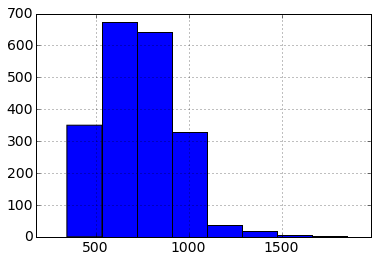

In [90]:
(df['gran']/1000).hist(bins=20)
plt.xlim(180, 1980)


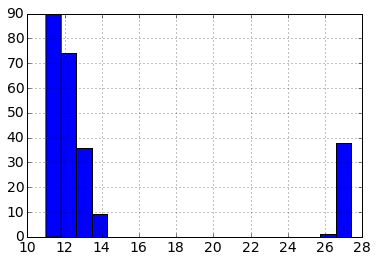

In [91]:
elv_init_select = np.zeros([len(df)],dtype=np.float)
for index1, row in df.iterrows():
    gran_km1 = row['gran']/1000.
    if gran_km1 > 900 and gran_km1 < 1000:
        elv_init_select[index1] = df['elv_init'][index1]
    else:
        elv_init_select[index1] = nan
df['elv_init_select'] = elv_init_select
df['elv_init_select'].hist(bins=20)

(-100, 100)

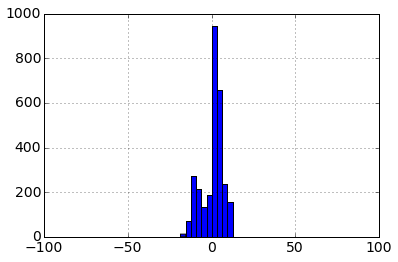

In [92]:
df['lgc_diff_2p'].hist(bins=10)
plt.xlim(-100, 100)


In [93]:
df['lgc_diff_2p'].describe()

count    2876.000000
mean        0.561897
std         6.303629
min       -18.549938
25%        -2.445399
50%         2.173731
75%         4.335102
max        12.591084
Name: lgc_diff_2p, dtype: float64

(-200, 200)

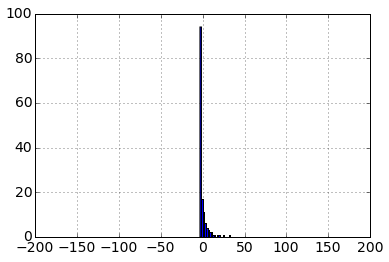

In [94]:
dgs['lgc_gs_diff_2p'].hist(bins=20)
plt.xlim(-200, 200)


In [95]:
dgs['lgc_gs_diff_2p'].describe()

count    145.000000
mean       0.083690
std        5.194797
min       -3.248309
25%       -2.404485
50%       -1.829297
75%       -0.056804
max       32.998408
Name: lgc_gs_diff_2p, dtype: float64

In [96]:
df['lgc_diff_sm'].describe()

count    2876.000000
mean      -49.477344
std        88.373484
min      -303.961623
25%      -133.191941
50%       -13.223966
75%        26.210566
max        63.217399
Name: lgc_diff_sm, dtype: float64

(-300, 300)

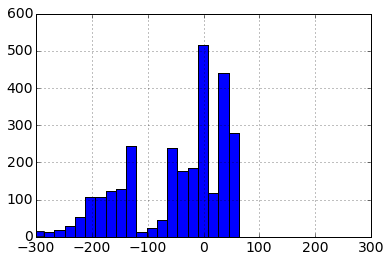

In [97]:
df['lgc_diff_sm'].hist(bins=20)
plt.xlim(-300, 300)

In [98]:
#df['h_2p'].describe()

In [99]:
#df['lgc_diff_cm'].hist(bins=20)
#plt.xlim(-300, 200)

In [100]:
#df['lgc_diff_cm'].describe()

(-0.1, 0.1)

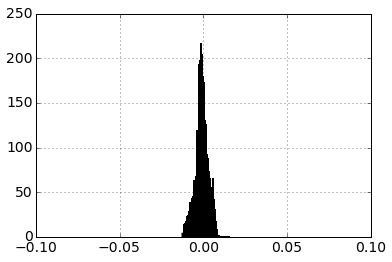

In [101]:
df['nr_diff_2p'].hist(bins=50)
plt.xlim(-0.1, 0.1)

In [102]:
df['nr_diff_2p'].describe()

count    2876.000000
mean       -0.001110
std         0.004053
min        -0.012670
25%        -0.003259
50%        -0.001194
75%         0.001295
max         0.015624
Name: nr_diff_2p, dtype: float64

In [103]:
df.to_csv(os.path.join(home_dir,'Desktop/data.csv'))

In [104]:
#df['nr_2p'].describe()